In [1]:
import pandas as pd
import numpy as np
import sys, os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import recall_score, accuracy_score, precision_score, roc_auc_score


## Data Cleaning

In [2]:
root = 'data/Presential_Speeches'

In [3]:
test = 'data/Presential_Speeches'

In [4]:
test[-9:]

'_Speeches'

### Get all document paths

In [5]:
all_docs = []
for path, sub, filen in os.walk(root):
#     print 'PPP', path
#     print 'SSS', sub
#     print 'FFF', filen
    if path[-9:]!='_Speeches':
        for f in filen:
            doc_path = path+'/'+f
            all_docs.append(doc_path)

In [6]:
#all_docs

In [7]:
df = pd.DataFrame({'path':all_docs, 'doc_id':range(1,len(all_docs)+1)})

In [8]:
('data/Presential_Speeches/').split('/')

['data', 'Presential_Speeches', '']

In [9]:
df['president'] = df['path'].apply(lambda x: x.split('/')[2])

In [10]:
def read_file(path):
    with open(path) as f:
        content = f.read()
    #postString = content.split("\n")[2]
    return content


In [11]:
df['speech_content'] = df['path'].apply(read_file)

In [12]:
pd.set_option('display.max_colwidth', -1)

In [13]:
#df.head()

In [14]:
df.shape

(962, 4)

In [15]:
#df.head()

### Manually tag each president's party

In [16]:
pre_par = {'adams': 'Federalist',
 'arthur': 'Republican',
 'bharrison': 'Republican',
 'buchanan': 'Democratic',
 'bush': 'Republican',
 'carter': 'Democratic',
 'cleveland': 'Democratic',
 'clinton': 'Democratic',
 'coolidge': 'Republican',
 'eisenhower': 'Republican',
 'fdroosevelt': 'Democratic',
 'fillmore': 'Whig',
 'ford': 'Republican',
 'garfield': 'Republican',
 'grant': 'Republican',
 'gwbush': 'Republican',
 'harding': 'Republican',
 'harrison': 'Whig',
 'hayes': 'Republican',
 'hoover': 'Republican',
 'jackson': 'Democratic',
 'jefferson': 'Democratic-Republican',
 'johnson': 'National Union',
 'jqadams': 'Democratic-Republican',
 'kennedy': 'Democratic',
 'lbjohnson': 'Democratic',
 'lincoln': 'Republican',
 'madison': 'Democratic-Republican',
 'mckinley': 'Republican',
 'monroe': 'Democratic-Republican',
 'nixon': 'Republican',
 'obama': 'Democratic',
 'pierce': 'Democratic',
 'polk': 'Democratic',
 'reagan': 'Republican',
 'roosevelt': 'Republican',
 'taft': 'Republican',
 'taylor': 'Whig',
 'truman': 'Democratic',
 'tyler': 'Whig',
 'vanburen': 'Democrat',
 'washington': 'none',
 'wilson': 'Democratic'}

In [17]:
df['party'] = df['president'].apply(lambda x: pre_par[x])

In [18]:
#df[['president','party']].head(80)

In [19]:
df_new = df[(df['party']=='Republican')|(df['party']=='Democratic')]

In [20]:
# take only republican and democratic presidents to train the models
df_new.shape

(797, 5)

### Examine the class balance between Republican and Democratic

In [21]:
1.*sum(df_new['party']=='Republican')/df_new.shape[0]

0.45294855708908405

**looks pretty balanced**

In [22]:
#X = df_new[['path','speech_content']]
X = df_new['speech_content']
y = df_new['party']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [23]:
X.shape

(797,)

In [24]:
#X.head()

In [25]:
1.*sum(y=='Republican')/y.shape[0]

0.45294855708908405

In [26]:
1.*sum(y_test=='Republican')/y_test.shape[0]

0.525

### Text Data Preprocessing

In [27]:
vectorizer = TfidfVectorizer(stop_words='english')

In [28]:
X_train_dtm = vectorizer.fit_transform(X_train)
X_test_dtm = vectorizer.transform(X_test)

In [29]:
X_train_dtm.shape

(597, 29585)

In [30]:
X_test_dtm.shape

(200, 29585)

### Modeling

**Logistic Regression**

In [29]:
from nltk.stem.snowball import PorterStemmer

stemmer = PorterStemmer()
analyzer = CountVectorizer().build_analyzer()

def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

**Due to computation limit, here I used only PorterStemmer. With distributed computation, more stemming/lemmatization choices can be tested in GridSearch**

In [205]:
# Gridsearch on text feature extractor and classfier hyper params
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', analyzer=stemmed_words)),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression()),
])

parameters = {
    'vect__max_df': (0.5, 0.75),
    #'vect__max_features': (None, 5000, 10000),
    'vect__ngram_range': ((1, 2), (1, 3)),  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    'clf__C':[0.01,0.1,1],
    'clf__penalty': ('l2', 'l1')
    #'clf__n_iter': (10, 50, 80),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed: 17.1min finished


Best score: 0.739
Best parameters set:


In [207]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

	clf__C: 1
	clf__penalty: 'l2'
	vect__max_df: 0.5
	vect__ngram_range: (1, 2)


In [208]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', analyzer=stemmed_words, max_df=0.5, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer(norm='l2')),
    ('clf', LogisticRegression(C=1, penalty='l2')),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x1a1e3e8050>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=0.5,
        max_features=None, min_df=1, ngram_range=(1, 2), preprocessor=...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [209]:
y_pred = pipeline.predict(X_test)

In [218]:
y_test_num = y_test=='Republican'
y_pred_num = y_pred=='Republican'

In [280]:
accuracy_score(y_test_num, y_pred_num)

0.755

In [284]:
precision_score(y_test_num, y_pred_num)

0.84848484848484851

In [285]:
recall_score(y_test_num, y_pred_num)

0.58947368421052626

In [287]:
roc_auc_score(y_test_num, y_pred_num)

0.74711779448621551

**Naive Bayes**

In [30]:
y_train_num = y_train=='Republican'

In [34]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()

def lemm_words(doc):
    return (lemm.lemmatize(w) for w in analyzer(doc))

In [32]:
pipeline = Pipeline([
    #('vect', CountVectorizer(stop_words='english', analyzer=lemm_words)),
    ('vect', CountVectorizer(stop_words='english', analyzer=stemmed_words)),
    #('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB())
])

parameters = {
    'vect__max_df': (0.5, 0.75),
    #'vect__max_features': (None, 5000, 10000),
    'vect__ngram_range': ((1, 1), (1, 2))  # unigrams or bigrams
    #'tfidf__use_idf': (True, False),
    #'tfidf__norm': ('l1', 'l2'),
    #'clf__alpha':[1,None]
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train_num)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.0min finished


Best score: 0.715
Best parameters set:
	vect__max_df: 0.5
	vect__ngram_range: (1, 1)


In [ ]:
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [33]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english', analyzer=stemmed_words, max_df=0.5, ngram_range=(1,1))),
    ('clf', MultinomialNB())
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer(analyzer=<function stemmed_words at 0x1a1b349f50>,
        binary=False, decode_error=u'strict', dtype=<type 'numpy.int64'>,
        encoding=u'utf-8', input=u'content', lowercase=True, max_df=0.5,
        max_features=None, min_df=1, ngram_range=(1, 1), preprocessor=...one,
        vocabulary=None)), ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [34]:
y_pred = pipeline.predict(X_test)

In [35]:
y_test_num = y_test=='Republican'
y_pred_num = y_pred=='Republican'

In [36]:
accuracy_score(y_test_num, y_pred_num)

0.75

**Precision score is slightly lower compare to Logistic Regression**

In [37]:
precision_score(y_test_num, y_pred_num)

0.79761904761904767

**Recall score is higher compare to Logistic Regression**

In [38]:
recall_score(y_test_num, y_pred_num)

0.67000000000000004

## Extra steps to explore the corpus

### What if we forget about the "party label", and do a unsupervised learning?

In [31]:
df.columns

Index([u'doc_id', u'path', u'president', u'speech_content', u'party'], dtype='object')

In [32]:
df_cluster = df['speech_content']

In [35]:
vectorizer = TfidfVectorizer(stop_words='english', analyzer=lemm_words, max_features=15000)
X_dtm = vectorizer.fit_transform(X)

In [36]:
X_dtm.shape

(797, 15000)

In [37]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
model = PCA(n_components=20)
model.fit(X_dtm.todense())

PCA(copy=True, n_components=20, whiten=False)

### Use scree plot to visualize latent feature importance

In [41]:
def scree_plot(pca, title=None):
    num_components = pca.n_components_
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    plt.figure(figsize=(10, 6), dpi=250)
    ax = plt.subplot(111)
    ax.bar(ind, vals, 0.35)

    for i in xrange(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=8)
    
    plt.xticks(range(num_components), ind)
    #ax.set_xticklabels(ind, fontsize=6)

    ax.set_ylim(0, max(vals)+0.05)
    ax.set_xlim(0-0.5, 20)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)

    ax.set_xlabel("Principal Component", fontsize=6)
    ax.set_ylabel("Variance Explained (%)", fontsize=6)

    if title is not None:
        plt.title(title, fontsize=16)

In [42]:
model.n_components_

20

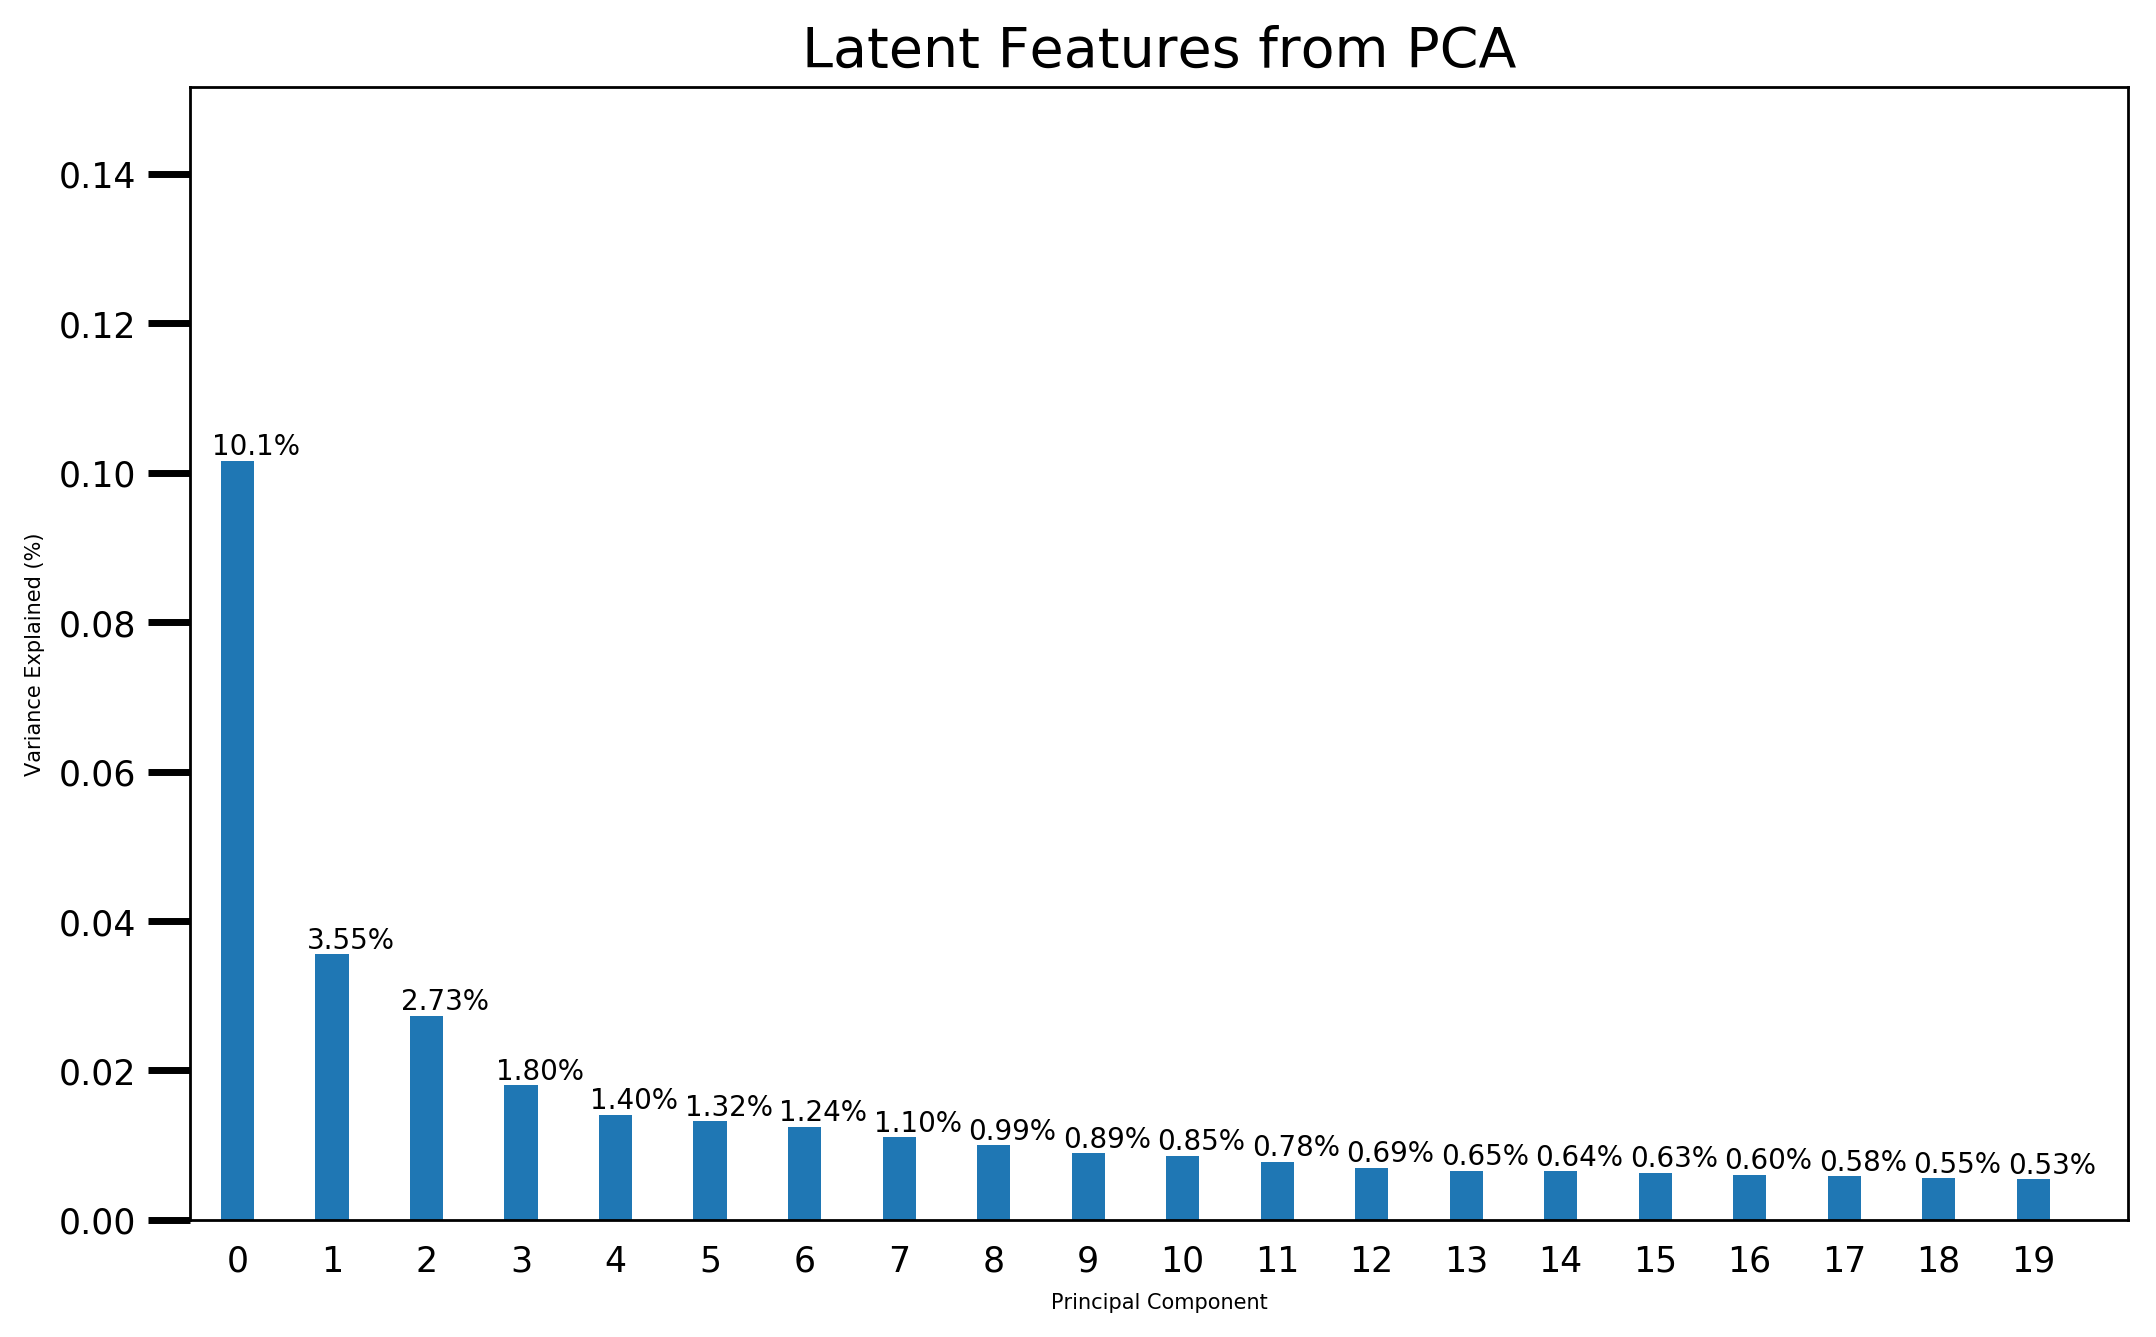

In [43]:
scree_plot(model, title='Latent Features from PCA')

### The first 3 components shows significant variance explanation

In [44]:
from sklearn.decomposition import NMF

In [62]:
model2 = NMF(n_components=10)
W = model2.fit_transform(X_dtm)
H = model2.components_

### We can examine H matrix to see what are some top words for each latent features

In [63]:
vocab = np.array(vectorizer.get_feature_names())

In [64]:
from wordcloud import WordCloud, STOPWORDS

### Topic Examine Result:

1 :  have wa is at a with this from our upon 000 were are on state to it congress these year an people country had great they there interest other under made during war tariff time than condition united department one relation party some between present expenditure result republic labor his foreign army into treaty their he service policy last industry report per commission large whole land bond number increase business measure two cent now national should power method island would fact navy amount will capital through revenue all further nation house public commerce secretary bank commercial system men organization necessity 



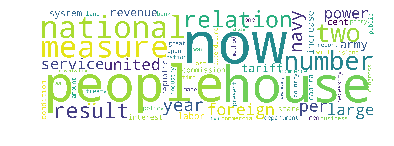

2 :  u not are all world nation but will who must this have their american freedom america people be with life a can no peace those they men today every great or new which own war free more from day let so man here human god hope know democracy cannot never when right my ha his them only heart do one what by these come liberty on country spirit live child faith woman ourselves time responsibility task citizen history than you your sacrifice many friend fellow shall justice generation century there at together society courage common work strength future because ideal 



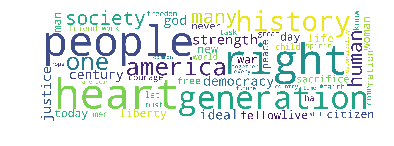

3 :  president this think mr they what wa are he for your do going on there but people about don not a who know be ve say my would all want can very had here re me when some if so with get one will been thing them just or am at out how were because time go got now republican said senator up u those tell country like come question ha his from year well right did believe thank day see any then governor back something way could much down white kennedy him great ll vote didn make lot good 



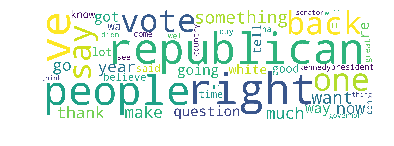

4 :  this for nation weapon our will is on be union missile united with it arm treaty agreement a strategic war europe force berlin have threat an security state must negotiation gorbachev israel defense all would east but military ha new ally other are year not communist moscow can international by freedom these mr control also nato today now west aggression geneva talk afghanistan people policy western let agreed human peaceful offensive area free both ve more sdi summit commitment if germany israeli conflict between from effort toward there at meeting ballistic no palestinian range continue proposal goal reduction economic hope 



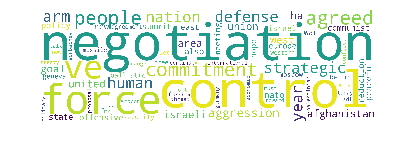

5 :  in for it who job laughter america she they what so here is more on are got can because want just her this or their child not school but get folk family make american thank grace don know about from college a like ll u health worker work up care student with right every senior will kid how when where middle terrorist reform israel economy audience why your medicare by year insurance company class people new need hard have country now going back change business everybody gabby immigrant generation time if better idea wa young sure vote afghanistan immigration believe 



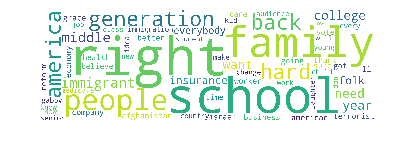

6 :  in such hereby said territory person all be shall law whereof aforesaid affixed any seal day hereunto act vessel on indian may thereof a jurisdiction within caused independence city treaty citizen port at secretary washington cuba that this america against authority unlawful panama their therefore warn set do testimony military article for government with respective date july hand april grant belligerent constitution my force congress admonish part combination legislature disperse officer neutrality from grover hundred 1869 resolution title hamilton done peaceably obstruction expedition violation 1898 land republic fish same regarding his mexico declare executive proclaim ulysses hayes enjoin james now 



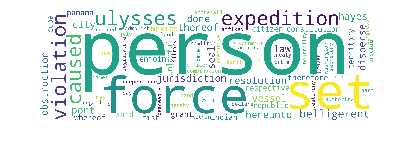

7 :  this more that is job on american program budget energy congress new america have ve it work economy with help are federal tonight cut percent must billion by oil child can inflation re health family people government economic deficit million business now spending need rate but income plan bill be than make care school a increase worker from price cost reform their about ha you system do drug unemployment should growth get these an they community let challenge time last dollar up investment u 000 every pay all problem next ll thank one insurance education also working over reduce recovery 



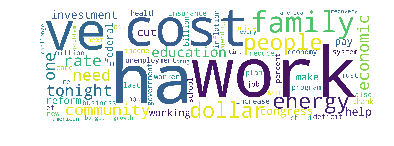

8 :  north war will american our is this are hanoi communist with would asia on for president a viet nam bombing southeast tonight ha be aggression any end united been not at force enemy think conference cambodia action negotiation military their other withdrawal mr paris there representative it decision men troop ambassador people by casualty now very year dominican talk they state made an do nation prisoner agreement can indochina from am all fighting effort these some week evening time vietcong republic support government last world negotiate ally goal attack cease month area side involvement situation sanctuary shall against 1966 statement 



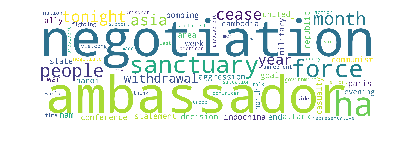

9 :  law should any their such for by this no may with shall will constitution public my if would right bill upon of all power them duty but can subject senate an provision are question so without on appropriation those state general officer from act congress object proper they necessary citizen under who every view authority currency executive consideration message union present money might me make attention property territory legislation purpose constitutional case in only treasury country improvement section ought election silver opinion when am mean must desire court mexico either principle government character nor other required thus claim provided made 



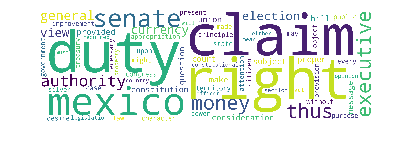

10 :  we kuwait hussein regime coalition troop that force al war is security with their qaeda for have america military this afghanistan nation american are weapon people on world they mission terror united attack baghdad enemy it tonight ha middle ve council a saudi from woman extremist country east victory operation not region gulf mass against innocent threat combat fight re help sectarian these by ally partner civilian be all who qaida arabia he home strategy destruction resolution aggression afghan commander end them dictator more oil iran arab homeland an after kuwaiti violence 1991 you sanction inspector new build chemical army 



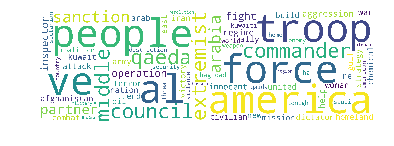

In [65]:
i = 1
for lf in H:
    #print type(lf)
    # Get the top 100 most important words starting from after some common words
    idx = lf.argsort()[::-1][11:111]
    top_w = vocab[idx]
    word_string = ' '.join(top_w)
    print i,': ',word_string, '\n'
    wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white',
                          width=3000,
                          height=1000
                         ).generate(word_string)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    i += 1